## Analysis of Housing and Homelessness

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress

# US Census setup
from census import Census
from us import states
from config import census_key

In [ ]:
# Define function to retrieve US censue data for a specfic year and return a dataframe
def get_census_data(year):
    census_library = Census(census_key, year=year)
    state_code = states.CA.fips
    variables = [
        'NAME',
        'B01003_001E',  # Population
        'B25014_001E',  # Total Housing units or B25001_001E
        'B25014_005E',  # Housing units owner occupied, 1-1.5 occupants per room
        'B25014_006E',  # Housing units owner occupied, 1.5-2 occupants per room
        'B25014_007E',  # Housing units owner occupied, >2 occupants per room
        'B25014_011E',  # Housing units renter occupied, 1-1.5 occupants per room
        'B25014_012E',  # Housing units renter occupied, 1.5-2 occupants per room
        'B25014_013E',  # Housing units renter occupied, >2 occupants per room   
        'B25106_003E',  # Housing units owner occupied, income <20K
        'B25106_006E',  # Housing units owner occupied, income <20K, housing costs >=30% of income
        'B25106_007E',  # Housing units owner occupied, income 20-35K
        'B25106_010E',  # Housing units owner occupied, income 20-35K, housing costs >=30% of income
        'B25106_011E',  # Housing units owner occupied, income 35-50K
        'B25106_014E',  # Housing units owner occupied, income 35-50K, housing costs >=30% of income
        'B25106_015E',  # Housing units owner occupied, income 50-75K
        'B25106_018E',  # Housing units owner occupied, income 50-75K, housing costs >=30% of income
        'B25106_019E',  # Housing units owner occupied, income >75K
        'B25106_022E',  # Housing units owner occupied, income >75K, housing costs >=30% of income
        'B25106_025E',  # Housing units renter occupied, income <20K
        'B25106_028E',  # Housing units renter occupied, income <20K, housing costs >=30% of income
        'B25106_029E',  # Housing units renter occupied, income 20-35K
        'B25106_032E',  # Housing units renter occupied, income 20-35K, housing costs >=30% of income
        'B25106_033E',  # Housing units renter occupied, income 35-50K
        'B25106_036E',  # Housing units renter occupied, income 35-50K, housing costs >=30% of income
        'B25106_037E',  # Housing units renter occupied, income 50-75K
        'B25106_040E',  # Housing units renter occupied, income 50-75K, housing costs >=30% of income
        'B25106_041E',  # Housing units renter occupied, income >75K
        'B25106_044E'   # Housing units renter occupied, income >75K, housing costs >=30% of income 
    ]

    # Retrieve data for all counties in California
    data = census_library.acs5.state_county(variables, state_code, Census.ALL)

    # Convert to dataframe
    df = pd.DataFrame(data)
    df['Year'] = year

    # Return the dataframe
    return df

In [ ]:
# Retrieve census data for multiple years and merge into one dataframe
years = [2017, 2018, 2019, 2020, 2021]

# https://blog.finxter.com/how-to-create-a-python-list-of-size-n/
year_df = [None] * len(years)
for year in years:
    year_df[year - 2017] = get_census_data(year)

# https://www.geeksforgeeks.org/merge-two-dataframes-with-same-column-names/
housing_df = pd.concat(year_df, axis=0)

# Export raw data to csv
url_path = Path('output_data/housing_raw_data.csv')
housing_df.to_csv(url_path, index=False)

housing_df

In [2]:
# Use this to recreate dataframe if starting a new Jupyter session or Kernal
url_path = Path('output_data/housing_raw_data.csv')
housing_df = pd.read_csv(url_path)

In [3]:
# Clean up data and add calculated columns

# Rename existing columns
housing_df = housing_df.rename(
    columns = {
        'NAME': 'County',
        'B01003_001E': 'Population',
        'B25014_001E': 'Total Housing Units'
    }
)

# Remove California from data in County column
housing_df['County'] = housing_df['County'].str.replace(', California','')

# Add columns rolling up data on overcrowded housing units
housing_df['Units Overcrowded'] = housing_df['B25014_005E'] + housing_df['B25014_011E']
housing_df['Units Severely Overcrowded'] = (housing_df['B25014_006E'] + housing_df['B25014_007E'] +
                                            housing_df['B25014_012E'] + housing_df['B25014_013E']
                                           )

# Add columns rolling up data on housing units based on housing costs and household income
housing_df['Units Income < 50K'] = (housing_df['B25106_003E'] + housing_df['B25106_007E'] +
                                    housing_df['B25106_011E'] + housing_df['B25106_015E'] +
                                    housing_df['B25106_019E'] + housing_df['B25106_025E'] +
                                    housing_df['B25106_029E'] + housing_df['B25106_033E'] +
                                    housing_df['B25106_037E'] + housing_df['B25106_041E']
                                   )
housing_df['Units Costs >= 30%'] = (housing_df['B25106_006E'] + housing_df['B25106_010E'] +
                                    housing_df['B25106_014E'] + housing_df['B25106_018E'] + 
                                    housing_df['B25106_022E'] + housing_df['B25106_028E'] +
                                    housing_df['B25106_032E'] + housing_df['B25106_036E'] +
                                    housing_df['B25106_040E'] + housing_df['B25106_044E']
                                   )

# Remove unneeded columns
# https://sparkbyexamples.com/pandas/pandas-drop-columns-by-index/
housing_clean_df = housing_df.drop(housing_df.iloc[:, 3:31], axis = 1)

# Export clean data to csv
url_path = Path('output_data/housing_clean_2021.csv')
housing_clean_df.to_csv(url_path, index=False)

# Print the dataframe
housing_clean_df.head()

,County,Population,Total Housing Units,Year,Units Overcrowded,Units Severely Overcrowded,Units Income < 50K,Units Costs >= 30%
0,Merced County,267390.0,79261.0,2017,5576.0,1711.0,75447.0,29818.0
1,Lake County,64095.0,26327.0,2017,505.0,275.0,24890.0,10623.0
2,Mariposa County,17658.0,7434.0,2017,76.0,37.0,7110.0,2378.0
3,Modoc County,9017.0,3638.0,2017,80.0,17.0,3458.0,1191.0
4,Yuba County,74644.0,25880.0,2017,1209.0,534.0,25061.0,10093.0


In [4]:
# Create final housing dataframe that includes CoC
url_path = Path('Resources/County-CoC Mapping.csv')
coc_mapping = pd.read_csv(url_path)

# Create new dataframe with housing and CoC data
housing_coc_df = pd.merge(housing_clean_df, coc_mapping, on=['County'], how='left')
housing_coc_df = housing_coc_df.groupby(['Year', 'Continuum of Care']).sum(numeric_only=True).reset_index()

print(len(housing_coc_df))
housing_coc_df

205


,Year,Continuum of Care,Population,Total Housing Units,Units Overcrowded,Units Severely Overcrowded,Units Income < 50K,Units Costs >= 30%
0,2017,Alameda County CoC,1629615.0,569070.0,27872.0,13657.0,556059.0,218874.0
1,2017,"Alpine, Inyo, Mono Counties CoC",33456.0,13229.0,196.0,64.0,12584.0,4244.0
2,2017,"Amador, Calaveras, Mariposa, Tuolumne Counties...",153920.0,61698.0,1032.0,314.0,59610.0,22211.0
3,2017,Butte County CoC,225207.0,86167.0,1879.0,685.0,83319.0,34750.0
4,2017,"Colusa, Glenn, Trinity Counties CoC",62451.0,22445.0,935.0,270.0,21382.0,7738.0
...,...,...,...,...,...,...,...,...
200,2021,Stanislaus County CoC,550842.0,175067.0,9335.0,3221.0,169908.0,63988.0
201,2021,Tehama County CoC,65345.0,24551.0,623.0,362.0,23609.0,8415.0
202,2021,Ventura County CoC,845255.0,274471.0,11812.0,5578.0,267629.0,110881.0
203,2021,Yolo County CoC,216703.0,75471.0,3444.0,1392.0,72788.0,27073.0


In [5]:
# Use this to recreate dataframe if starting a new Jupyter session or Kernal
url_path = Path('resources/experiencing_homelessness_age_demographics.csv')
homeless_df = pd.read_csv(url_path)

In [6]:
# Clean up homeless data and prep to merge with housing data

# Rename existing columns
homeless_df = homeless_df.rename(
    columns = {
        'CALENDAR_YEAR': 'Year',
        'COC_ID': 'CoC Code',
        'COC_NAME': 'Continuum of Care',
        'EXPERIENCING_HOMELESSNESS_CNT': 'Homeless Count'
    }
)

# Change homeless count data type to integer
homeless_df = homeless_df.loc[homeless_df['Homeless Count']!='*']
homeless_df['Homeless Count'] = homeless_df['Homeless Count'].astype(int)

# Remove counts for all of California
homeless_df = homeless_df.loc[homeless_df['Continuum of Care'] != 'California']

# Rename multiple CoCs in LA so they roll up into one number per year
la_cocs = ['Glendale CoC (Los Angeles County)', 'Pasadena CoC (Los Angeles County)', 'Long Beach CoC (Los Angeles County)']
homeless_df['Continuum of Care'] = homeless_df['Continuum of Care'].replace(la_cocs, 'Los Angeles County CoC')

# Group by year and COC name and sum homeless counts
homeless_df = homeless_df.groupby(['Year', 'Continuum of Care'])['Homeless Count'].sum().reset_index()


# Print row and countthe dataframe
print(len(homeless_df))
# homeless_df

244


In [8]:
# Create final dataframe merging housing and homeless data
final_df = pd.merge(housing_coc_df, homeless_df, on=['Year','Continuum of Care'], how='left')

# Add columns to calculate %s of overcrowded units
final_df['% Units Overcrowded'] = (final_df['Units Overcrowded'] /
                                   final_df['Total Housing Units']) * 100
final_df['% Units Severely Overcrowded'] = (final_df['Units Severely Overcrowded'] /
                                            final_df['Total Housing Units']) * 100
final_df['% Units All Overcrowded'] = ((final_df['Units Overcrowded'] +
                                        final_df['Units Severely Overcrowded']) /
                                       final_df['Total Housing Units']) * 100

# Add columns to calculate % of housing units with costs >= 30%
final_df['% Units Inc < 50K Costs >= 30%'] = (final_df['Units Costs >= 30%'] /
                                              final_df['Units Income < 50K']) * 100
final_df['% Units Costs >= 30%'] = (final_df['Units Costs >= 30%'] /
                                    final_df['Total Housing Units']) * 100

# Add column to calculation homeless % of population
final_df['% Homeless'] = (final_df['Homeless Count'] /
                          final_df['Population']) * 100

# Drop rows with missing data
final_df = final_df.loc[final_df['Continuum of Care'] != 'Yuba, Sutter Counties CoC']

# Export final data to csv
url_path = Path('output_data/housing_final_data.csv')
final_df.to_csv(url_path, index=False)

# Print the dataframe
final_df


,Year,Continuum of Care,Population,Total Housing Units,Units Overcrowded,Units Severely Overcrowded,Units Income < 50K,Units Costs >= 30%,Homeless Count,% Units Overcrowded,% Units Severely Overcrowded,% Units All Overcrowded,% Units Inc < 50K Costs >= 30%,% Units Costs >= 30%,% Homeless
0,2017,Alameda County CoC,1629615.0,569070.0,27872.0,13657.0,556059.0,218874.0,6713.0,4.897816,2.399881,7.297696,39.361650,38.461701,0.411938
1,2017,"Alpine, Inyo, Mono Counties CoC",33456.0,13229.0,196.0,64.0,12584.0,4244.0,151.0,1.481593,0.483786,1.965379,33.725366,32.081034,0.451339
2,2017,"Amador, Calaveras, Mariposa, Tuolumne Counties...",153920.0,61698.0,1032.0,314.0,59610.0,22211.0,368.0,1.672664,0.508931,2.181594,37.260527,35.999546,0.239085
3,2017,Butte County CoC,225207.0,86167.0,1879.0,685.0,83319.0,34750.0,1400.0,2.180649,0.794968,2.975617,41.707174,40.328664,0.621650
4,2017,"Colusa, Glenn, Trinity Counties CoC",62451.0,22445.0,935.0,270.0,21382.0,7738.0,190.0,4.165738,1.202941,5.368679,36.189318,34.475384,0.304239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2021,Sonoma County CoC,492498.0,188841.0,6476.0,2881.0,184068.0,73997.0,3885.0,3.429340,1.525622,4.954962,40.200904,39.184817,0.788836
200,2021,Stanislaus County CoC,550842.0,175067.0,9335.0,3221.0,169908.0,63988.0,5004.0,5.332244,1.839867,7.172111,37.660381,36.550578,0.908427
201,2021,Tehama County CoC,65345.0,24551.0,623.0,362.0,23609.0,8415.0,282.0,2.537575,1.474482,4.012057,35.643187,34.275590,0.431556
202,2021,Ventura County CoC,845255.0,274471.0,11812.0,5578.0,267629.0,110881.0,2347.0,4.303551,2.032273,6.335824,41.430861,40.398075,0.277668


## Summary Statistics

### Homelessness by Continuum of Care

In [ ]:
# Sort dataframe in descending order and show the top 10 homeless
homeless_top10 = housing_homeless_df.sort_values(by='% Homeless',ascending=False).iloc[:10]

# Create bar plot showing the top 10 continuums of care by homeless rate
x_axis = homeless_top10['Continuum of Care']
y_axis = homeless_top10['% Homeless']

plt.bar(x_axis,y_axis, color='tab:blue')
plt.xlabel('Continuum of Care')
plt.ylabel('% of Population')
plt.xticks(rotation=40, ha = 'right')
plt.title('CoCs with the Highest % of Population Experiencing Homelessness (2017-2020)')
plt.show()

In [ ]:
# https://dataplotplus.com/plot-two-variables-two-different-y-axes-in-pandas/
# fig, ax = plt.subplots(figsize=(20,10)) 
test = homeless_top10[['Continuum of Care', '% Homeless', '% Units Severely Overcrowded']]

fig, ax = plt.subplots()
test.plot(kind='bar', secondary_y = ['% Units Severely Overcrowded'], legend=False, ax=ax)
plt.show

In [ ]:
# Sort homeless rate in descending order and show the top,10
homeless_bottom10 = housing_homeless_df.sort_values(by='% Homeless',ascending=True).iloc[:10]

# Create bar plot showing the top 10 continuums of care by homeless rate
x_axis = homeless_bottom10['Continuum of Care']
y_axis = homeless_bottom10['% Homeless']

plt.bar(x_axis,y_axis, color='tab:blue')
plt.xlabel('Continuum of Care')
plt.ylabel('% of Population')
plt.xticks(rotation=40, ha = 'right')
plt.title('CoCs with the Lowest % of Population Experiencing Homelessness (2017-2020)')
plt.show()

In [32]:
def plot_box_whiskers(y_values, labels):
    
    fig1, ax1 = plt.subplots()
    ax1.set_ylabel(labels['y'])
    ax1.boxplot(y_values)
    plt.show()

### Linear Regression Analysis

In [9]:
# Function to create Linear Regression plots
def plot_lin_reg(x_values, y_values, labels):
    
    # set variables for linear regression and plot
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,'r-')
    
    # set location of regression equation - x is 5% to the right of the y axis
    xmin, xmax = plt.xlim()
    line_eq_xloc = round(xmin + ((xmax - xmin)* .05), 1)
    
    # increase ylim max by 10% and set location for regression equation - y is 1% above previous ylim max
    ymin, ymax = plt.ylim()
    plt.ylim(ymin, round(ymax + ((ymax - ymin) * .10), 1))
    line_eq_yloc = round(ymax + ((ymax - ymin) * .01), 1)     

    # add equation, set x/y axis labels and print r-value
    plt.annotate(line_eq,(line_eq_xloc, line_eq_yloc), fontsize=15, color='red')
    plt.xlabel(labels['x'])
    plt.ylabel(labels['y'])
    print(f'The r value is: {rvalue}')
    print(f'The p value is: {pvalue}')
    plt.show()

y1 40 y2 40
The r-squared is: 0.08680976442044815
The p value is: 0.07254591677151953


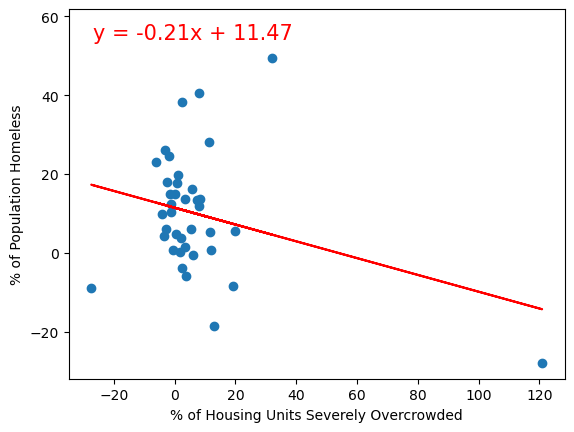

In [29]:
# Linear regression % Severely Overcrowded vs % of Homeless

# Set years for comparison
data_y1 = final_df[final_df['Year'] == 2018].reset_index()
data_y2 = final_df[final_df['Year'] == 2019].reset_index()

print(f'y1 {len(data_y1)} y2 {len(data_y2)}')


# Define x and y values and labels for function
labels = {'x': '% of Housing Units Severely Overcrowded',
          'y': '% of Population Homeless'}

# Calculate % change from year 1 to year 2
x_values = ((data_y2['% Units Severely Overcrowded'] - data_y1['% Units Severely Overcrowded']) /
            data_y1['% Units Severely Overcrowded']) * 100
y_values = ((data_y2['% Homeless'] - data_y1['% Homeless']) /
            data_y1['% Homeless']) * 100

x_values = x_values.drop([x_values.index[12], x_values.index[16]])
y_values = y_values.drop([y_values.index[12], y_values.index[16]])
x_values.reset_index()
y_values.reset_index()
#print(y_values)
#print(x_values)

# Call function to plot linear regression
plot_lin_reg(x_values, y_values, labels)

The r-squared is: 0.00546009211231304
The p value is: 0.2984007388261634


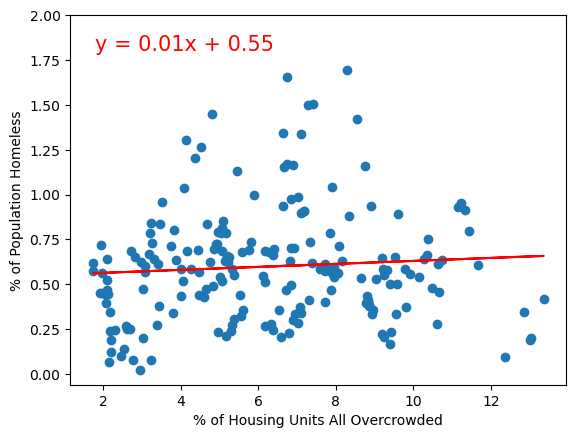

In [30]:
# Linear regression comparing Severely Overcrowded Housing Units and Homeless Count
# define x and y lables for function
labels = {'x': '% of Housing Units All Overcrowded',
          'y': '% of Population Homeless'}

# call function to plot linear regression
plot_lin_reg(final_df['% Units All Overcrowded'], final_df['% Homeless'], labels)

The r-squared is: 0.015101049548828073
The p value is: 0.08299645360532805


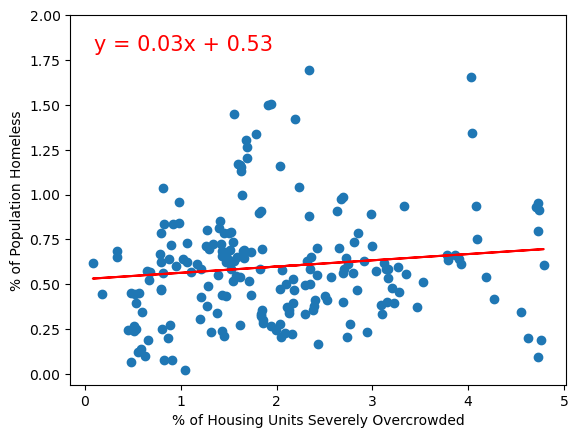

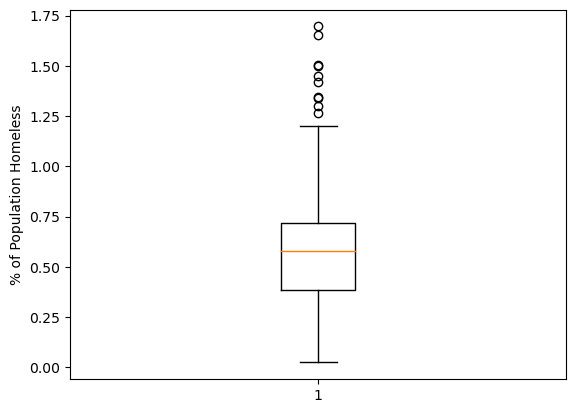

In [35]:
# Linear regression comparing Severely Overcrowded Housing Units and Homeless Count
# define x and y lables for function
labels = {'x': '% of Housing Units Severely Overcrowded',
          'y': '% of Population Homeless'}

# call function to plot linear regression
plot_lin_reg(final_df['% Units Severely Overcrowded'], final_df['% Homeless'], labels)

plot_box_whiskers(final_df['% Homeless'], labels)

In [ ]:
# Linear regression comparing Severely Overcrowded Housing Units and Homeless Count
# define x and y lables for function
labels = {'x': '% of Housing Units Overcrowded',
          'y': '% of Population Homeless'}

# call function to plot linear regression
plot_lin_reg(final_df['% Units Overcrowded'], final_df['% Homeless'], labels)

In [ ]:
# Linear regression

# Set years for comparison
data_y1 = final_df[final_df['Year'] == 2019].reset_index()
data_y2 = final_df[final_df['Year'] == 2021].reset_index()

# Define x and y values and labels for function
labels = {'x': '% of Housing Units with Costs >= 30% of Income',
          'y': '% of Population Homeless'}

# Calculate % change from year 1 to year 2
x_values = ((data_y2['% Units Costs >= 30%'] - data_y1['% Units Costs >= 30%']) /
            data_y1['% Units Costs >= 30%']) * 100
y_values = ((data_y2['% Homeless'] - data_y1['% Homeless']) /
            data_y1['% Homeless']) * 100

# Call function to plot linear regression
plot_lin_reg(x_values, y_values, labels)

In [ ]:
# Define x and y lables for function
labels = {'x': '% of Housing Units with Costs >30% of Household Income',
          'y': '% of Population Homeless',
          'title': ''}

x_values = final_df['% Units Costs >= 30%']
y_values = final_df['% Homeless']

# Call function to plot linear regression
plot_lin_reg(final_df['% Units Costs >= 30%'], final_df['% Homeless'], labels)

plot_box_whiskers(x_values, labels)

In [ ]:
# Define x and y lables for function
labels = {'x': 'Housing Units with Costs >30% of Household Income',
          'y': 'Homeless Count'}

# Call function to plot linear regression
plot_lin_reg(final_df['% Units Inc < 50K Costs >= 30%'], final_df['% Homeless'], labels)

In [ ]:
# For testing normal distribution of any data
#url_path = Path('output_data/housing_homeless_data.csv')
#housing_homeless_df = pd.read_csv(url_path)

test_data = final_df['% Units Costs >= 30%']
plt.hist(test_data)
plt.xlabel('Test')
plt.ylabel('Counts')
plt.show()
print(st.normaltest(test_data))